In [1]:
!pip install -q librosa

In [4]:
import librosa
from matplotlib import pyplot as plt
import numpy as np

In [17]:
def plot_vs_time(w, t, xlim=None, ylim=[-1, +1], fig=None, fmt='-'):
    fig, ax = plt.subplots(figsize=(12,3)) if fig is None else fig
    ax.plot(t,w,fmt)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(xlim) if xlim is not None else plt.xlim(t[0],t[-1])
    ax.set_ylim(ylim) if ylim is not None else None
    fig.tight_layout()
    ax.grid(visible=True)

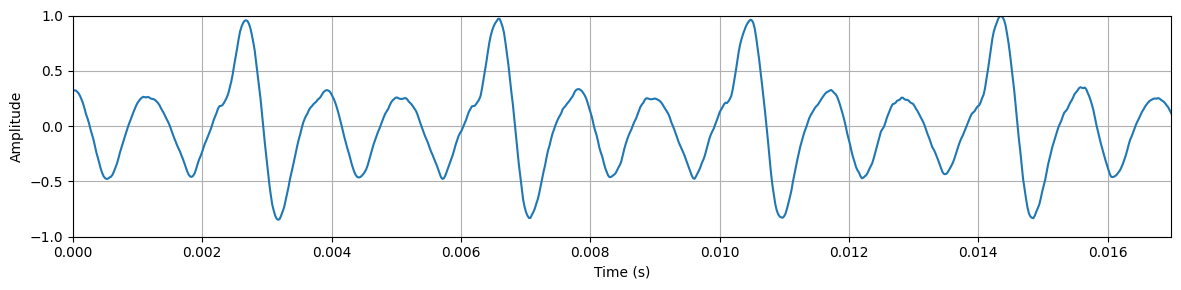

In [23]:
filename = "female_la_c4_short"
sig, fs = librosa.load(f"{filename}.wav", sr=44100)

sig = orig_signal[0:750] # extract excerpt
sig = sig - np.mean(sig) # remove mean

import IPython.display as ipd
ipd.Audio(sig, rate=fs)

plot_vs_time(sig, np.arange(len(sig))/fs)

# Compute normalized autocorrelation

* Select a lag value between 1 and 200

* Report the result in the GSheet [ead26.autocorrelation](https://docs.google.com/spreadsheets/d/1hd3VDAQS5ch96whm0OreCZDcYA3_FEObYCcGe72_A3k/edit?usp=sharing)

172 0.98


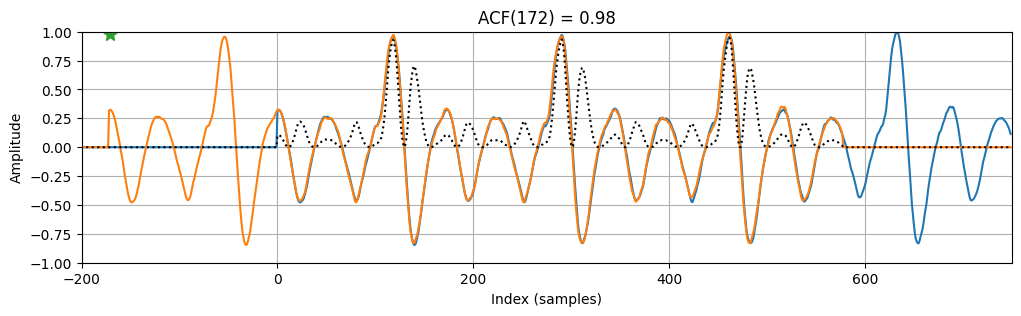

In [108]:
# SELECT LAG VALUE and COMPUTE AUTOCORRELATION for that lag #
#############################################################

# e.g. len(sig) = 10, k = 4
#
#          01234567890123456789
# sig      ----------**********   => sig[:-k]
# sig_k    ------**********----   => sig_k[k:]
# k         9876543210

# Use values in the range from 1 to 200
lag = k = 172 # TODO: e.g. 80


# ----------------


# Compute variance (for normalization)
n = len(sig)
variance = np.sum(sig**2) / n

sig_k = sig
acf_k = np.sum(sig_k[k:] * sig[:-k]) / (n-k)

# Normalize by variance
acf_k = acf_k / variance

sig_ext = np.concatenate([np.zeros(n-1), sig])
sig_k_ext = np.concatenate([np.zeros(n-1-k), sig, np.zeros(k)])

fig, ax1 = plt.subplots(figsize=(12,3), sharex=True)
ax1.plot(t,sig_ext)
ax1.plot(t,sig_k_ext)
ax1.plot(t, sig_ext * sig_k_ext, ':k')

dummy = [np.nan] * (2*n-1)
dummy[n-k] = acf_k
ax1.plot(t,dummy,'*',ms=10)

ax1.set_xlim(-len(sig),len(sig))
ax1.set_ylim(-1,1)
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Index (samples)')
ax1.set_title(f"ACF({k}) = {acf_k:.2f}")
ax1.grid(visible=True)

ax1.set_xlim(-200,n)
print(f"{k} {acf_k:.2f}")


Pitch range: 50Hz,750 <= k <=  500Hz,88


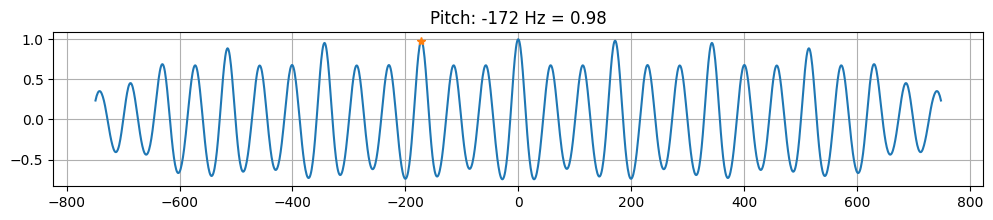

In [72]:
def autocorrelation_full(signal):
    """
    Compute autocorrelation from scratch with both positive and negative lags.
    """
    n = len(signal)

    # Compute variance (for normalization)
    variance = np.sum(signal**2) / n

    # Compute autocorrelation for negative and positive lags
    acf = np.zeros(2*n - 1)
    lag_v = np.zeros(2*n - 1)

    # Negative lags (from -(n-1) to -1)
    for lag in range(1, n):
        acf[n-lag-1] = np.sum(signal[lag:] * signal[:-lag]) / (n-lag)
        lag_v[n-lag-1] = -lag

    # Zero lag
    acf[n-1] = np.sum(signal * signal) / n
    lag_v[n-1] = 0

    # Positive lags (from 1 to n-1)
    for lag in range(1, n):
        acf[n-1+lag] = np.sum(signal[:-lag] * signal[lag:]) / (n-lag)
        lag_v[n-1+lag] = lag

    # Normalize by variance
    acf = acf / variance

    return acf, lag_v

# Example usage
n = len(sig)
acf, lag_v = autocorrelation_full(sig)

# Select only expected pitch range portion => acf_ and lag_v_
f0_max, f0_min = 500, 50
idx_max = min( np.round(fs/f0_min).astype(int), n) # bound to signal length
idx_min = max( np.round(fs/f0_max).astype(int), 0)
print(f"Pitch range: {f0_min}Hz,{idx_max} <= k <=  {f0_max}Hz,{idx_min}")
acf_ = acf[n-idx_max:n-idx_min]
lag_v_ = lag_v[n-idx_max:n-idx_min]

# Find max value and position
acf_max = np.max(acf_)
idx_max = np.argmax(acf_)
lag_max = lag_v_[idx_max]
n = len(sig)

# Plot ACF and MAX
fig, ax = plt.subplots(figsize=(12,2))
ax.plot(lag_v, acf)
ax.plot(lag_max, acf_max, '*')
ax.grid(visible=True)
ax.set_title(f"Pitch: {lag_max:.0f} Hz = {acf_max:.2f}")
plt.show()